In [1]:
# Run python sript if enter_parameters is needed.
# Run ipython or notebook with enter_parameters disabled if cell outputs need to be saved.
run_from_ipython = 'get_ipython' in globals()
# Use ipython display when running notebook. Print directly to console when running sript.
display = display if run_from_ipython else print

In [2]:
import os
import json
import numpy as np
import pandas as pd
import xarray as xr
import scipy as sp
import matplotlib.pyplot as plt

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

from utils import *
from process import *
from analysis import *
from plots import *

if run_from_ipython:
    %matplotlib inline

with open('config.json') as f:
    config = json.load(f)

In [3]:
# Cache directory path, it determines where downloaded data will be stored
manifest_path = os.path.join(config['cache_dir'], "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

# Whether to manually enter parameters for analysis
enter_parameters = config['enter_parameters']
whether_redo = redo_condition(enter_parameters)

## Get session and probe

In [4]:
session_id = config['analysis_object']['session_id']
ecephys_structure_acronym = config['analysis_object']['ecephys_structure_acronym']
session = cache.get_session_data(session_id)

In [5]:
output_dir = config['output_dir']
session_dir = os.path.join(output_dir, f'session_{session_id:d}')
info_file = os.path.join(output_dir, f'session_{session_id:d}_{ecephys_structure_acronym:s}.json')
with open(info_file) as f:
    info = json.load(f)
print(json.dumps(info, indent=4))

probe_id = info['probe_id']
probe_dir = os.path.join(session_dir, f'probe_{probe_id:d}')
parameters_dict = info['parameters']
fig_disp = figure_display_function(config)

{
    "session_id": 721123822,
    "ecephys_structure_acronym": "VISp",
    "probe_id": 760213145,
    "center_channel_id": 850245983,
    "center_unit_channel_id": 850245985,
    "fs": 1249.99999145772,
    "parameters": {
        "drifting_gratings_knee": true,
        "static_gratings_knee": false,
        "natural_scenes_knee": false,
        "natural_movie1_knee": true,
        "scaleogram_channels": 4,
        "power_freq_band": [
            20.0,
            40.0
        ],
        "fr_smooth_sigma": 0.02,
        "fr_normalization_scale": "range",
        "fr_normalize_quantile": 0.2
    },
    "has_ccf": true,
    "unit_has_ccf": true,
    "channel_group_by_ccf": true,
    "n_channel_groups": 8,
    "movies_pop_parameters": {
        "fr_smooth_sigma": 0.02,
        "fr_normalization_scale": "range",
        "fr_normalize_quantile": 0.2,
        "extend_time": 0.5,
        "beta_band": [
            20.0,
            40.0
        ],
        "gamma_band": [
            40.0,
 

## Load LFP channels

In [6]:
filepath = os.path.join(probe_dir, f'{ecephys_structure_acronym:s}_lfp_channel_groups.nc')
with xr.open_dataset(filepath) as f:
    lfp_array = f.load()
lfp_array = lfp_array.assign_attrs(fs=info['fs']).rename(group_id='channel')
display(lfp_array)

<xarray.Dataset>
Dimensions:  (time: 12263286, channel: 8)
Coordinates:
  * time     (time) float64 0.5328 0.5336 0.5344 ... 9.811e+03 9.811e+03
  * channel  (channel) int32 0 1 2 3 4 5 6 7
Data variables:
    LFP      (channel, time) float32 1.3e-06 1.82e-06 ... -1.55e-05 -8.287e-06
Attributes:
    fs:       1249.99999145772

In [7]:
channel_group_map = pd.read_csv(filepath.replace('.nc', '.csv'), index_col='id')
group_dv_ccf = dict(zip(channel_group_map['group_id'], channel_group_map['dorsal_ventral_ccf_coordinate']))
display(channel_group_map)

,group_id,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate
id,,,,
850245925,7,8547.555556,1430.000000,8020.000000
850245931,7,8547.555556,1430.000000,8020.000000
850245937,7,8547.555556,1430.000000,8020.000000
850245943,6,8581.888889,1329.333333,8025.888889
850245949,6,8581.888889,1329.333333,8025.888889
...,...,...,...,...
850246077,0,8848.666667,571.777778,8055.222222
850246079,0,8848.666667,571.777778,8055.222222
850246081,0,8848.666667,571.777778,8055.222222


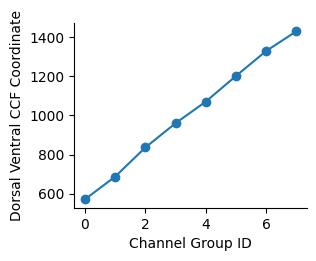

In [8]:
plt.figure(figsize=(3, 2.4))
plt.plot(group_dv_ccf.keys(), group_dv_ccf.values(), marker='o')
plt.xlabel('Channel Group ID')
plt.ylabel('Dorsal Ventral CCF Coordinate')
fig_disp('channel_group_coordinates')

## Analysis

In [9]:
stimulus_presentations = session.stimulus_presentations
channel_id = info['center_unit_channel_id']
group_id = channel_group_map.loc[channel_id, 'group_id']
# group_id = 5
print(f"Channel group: {group_id:d}")

psd_tseg = 1.0
psd_avg_das = {}

savefig = True
plt_range = (0, 100.)
sxx_plt_range = [2.0, 80.0]

Channel group: 4


### drifting_gratings

Channel:  4
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 1 - 200 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                    -7.1557, 288.6305, 2.2742                                     
                                                                                                  
                                       2 peaks were found:                                       

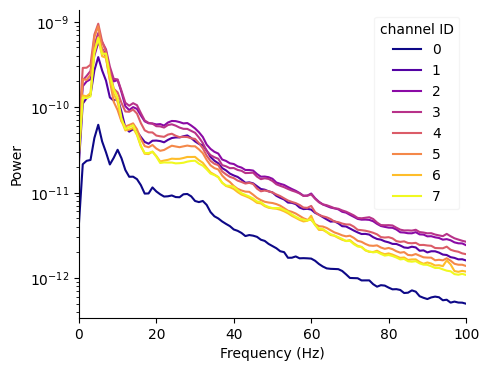

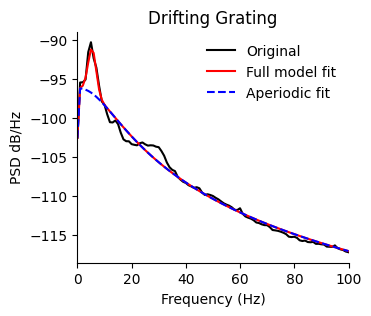

In [10]:
redo = True
while redo:
    ap_knee, = get_parameters({'drifting_gratings_knee': True}, parameters_dict, enter_parameters)
    aperiodic_mode = 'knee' if ap_knee else 'fixed'

    drifting_gratings_presentations, grating_ids, grating_times, grating_duration = align_gratings(
        stimulus_presentations, stimulus_name='drifting_gratings')
    aligned_lfp = align_trials(lfp_array, grating_ids, grating_times, window=(0., grating_duration))
    drifting_gratings_psd = trial_psd(aligned_lfp, tseg=psd_tseg)
    psd_avg = drifting_gratings_psd.mean(dim='presentation_id')
    fooof_result, fig1, _ = plot_channel_psd(psd_avg, channel_id=group_id, freq_range=200., plt_range=plt_range, figsize=(5, 4),
                                             aperiodic_mode=aperiodic_mode, dB_threshold=3., max_n_peaks=10, plot=not savefig, plt_log=True)


    psd_avg_das['drifting_grating'] = psd_avg
    if savefig:
        fig2, ax = plt.subplots(figsize=(3.5, 3))
        psd_avg_plt = psd_avg.sel(channel=group_id, frequency=slice(*plt_range))
        _ = plot_fooof(psd_avg_plt.frequency.values, psd_avg_plt.values, fooof_result[0], plt_log=False, plt_range=plt_range, plt_db=True, ax=ax)
        ax.set_title('Drifting Grating')
    fig_disp({'drifting_grating_psd': fig1, f'drifting_grating_fooof_channel_{group_id}': fig2})

    redo = whether_redo()

### static_gratings

Channel:  4
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 7 - 199 Hz                        
                                 Frequency Resolution is 3.75 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -7.8626, 1.9210                                          
                                                                                                  
                                       0 peaks were found:                                       

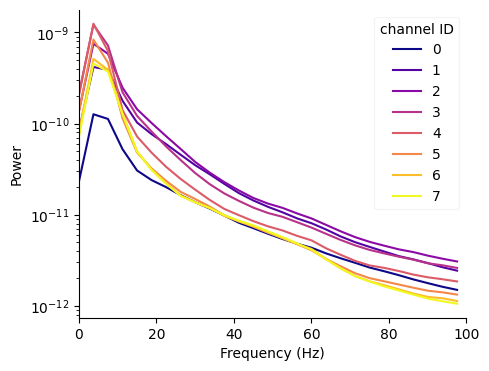

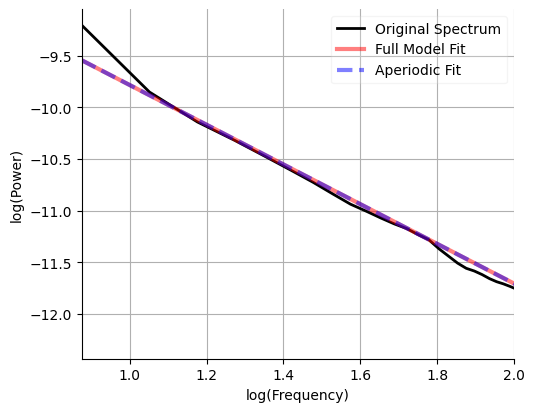

In [11]:
redo = True
while redo:
    ap_knee, = get_parameters({'static_gratings_knee': False}, parameters_dict, enter_parameters)
    aperiodic_mode = 'knee' if ap_knee else 'fixed'

    _, presentations_ids, presentations_times, trial_duration = align_gratings(stimulus_presentations, stimulus_name='static_gratings')
    aligned_lfp = align_trials(lfp_array, presentations_ids, presentations_times, window=(0., trial_duration))
    psd_avg = trial_psd(aligned_lfp, tseg=psd_tseg).mean(dim='presentation_id')

    psd_avg_das['static_grating'] = psd_avg
    _, fig1, fig2 = plot_channel_psd(psd_avg, channel_id=group_id, freq_range=200., plt_range=plt_range, figsize=(5, 4),
                         aperiodic_mode=aperiodic_mode, dB_threshold=3., max_n_peaks=10, plt_log=True)
    fig_disp({'static_grating_psd': fig1, f'static_grating_fooof_channel_{group_id}': fig2})

    redo = whether_redo()

Scalogram

In [12]:
# redo = True
# while redo:
#     channel_ids, = get_parameters({'scaleogram_channels': list(map(int, lfp_array.channel))}, parameters_dict, enter_parameters)

#     _, presentations_ids, presentations_times, trial_duration = align_gratings(stimulus_presentations, stimulus_name='static_gratings')
#     aligned_lfp = align_trials(lfp_array, presentations_ids, presentations_times, window=(-0.05, trial_duration + 0.05))

#     sxx_avg = trial_averaged_spectrogram(aligned_lfp, tseg=.25)
#     _ = plot_channel_spectrogram(sxx_avg, channel_id=channel_ids, plt_range=sxx_plt_range, log_power=True,
#                                  clr_freq_range=None, figsize=(6, 3.6),
#                                  remove_aperiodic={'freq_range': 200., 'aperiodic_mode': aperiodic_mode})
#     fig_disp('static_gratings_scaleogram')

#     redo = whether_redo()

### natural_scenes

Channel:  4
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 7 - 198 Hz                        
                                 Frequency Resolution is 3.53 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -8.0827, 1.7935                                          
                                                                                                  
                                       0 peaks were found:                                       

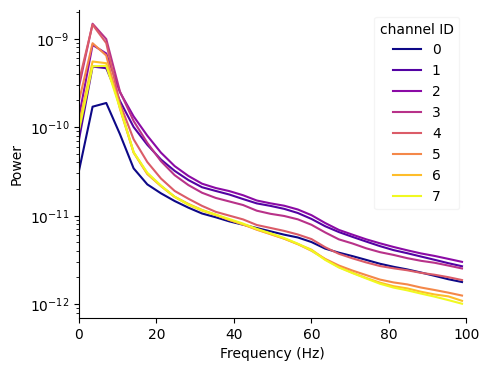

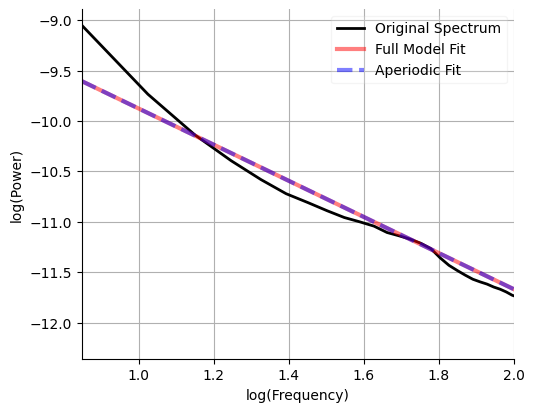

In [13]:
redo = True
while redo:
    ap_knee, = get_parameters({'natural_scenes_knee': False}, parameters_dict, enter_parameters)
    aperiodic_mode = 'knee' if ap_knee else 'fixed'

    _, presentations_ids, presentations_times, trial_duration = align_scenes(stimulus_presentations, stimulus_name='natural_scenes')
    aligned_lfp = align_trials(lfp_array, presentations_ids, presentations_times, window=(0., trial_duration))
    psd_avg = trial_psd(aligned_lfp, tseg=psd_tseg).mean(dim='presentation_id')

    psd_avg_das['natural_scenes'] = psd_avg
    _, fig1, fig2 = plot_channel_psd(psd_avg, channel_id=group_id, freq_range=200., plt_range=plt_range, figsize=(5, 4),
                         aperiodic_mode=aperiodic_mode, dB_threshold=3., max_n_peaks=10, plt_log=True)
    fig_disp({'natural_scenes_psd': fig1, f'natural_scenes_fooof_channel_{group_id}': fig2})

    redo = whether_redo()

Scalogram

In [14]:
# redo = True
# while redo:
#     channel_ids, = get_parameters({'scaleogram_channels': list(map(int, lfp_array.channel))}, parameters_dict, enter_parameters)

#     _, presentations_ids, presentations_times, trial_duration = align_scenes(stimulus_presentations, stimulus_name='natural_scenes')
#     aligned_lfp = align_trials(lfp_array, presentations_ids, presentations_times, window=(-0.05, trial_duration + 0.05))

#     sxx_avg = trial_averaged_spectrogram(aligned_lfp, tseg=.25)
#     _ = plot_channel_spectrogram(sxx_avg, channel_id=channel_ids, plt_range=sxx_plt_range, log_power=True,
#                                  clr_freq_range=None, figsize=(6, 3.6),
#                                  remove_aperiodic={'freq_range': 200., 'aperiodic_mode': aperiodic_mode})
#     fig_disp('natural_scenes_scaleogram')

#     redo = whether_redo()

### natural_movie_one

Channel:  4
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 1 - 200 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -8.2196, 30.7985, 1.7368                                     
                                                                                                  
                                       1 peaks were found:                                       

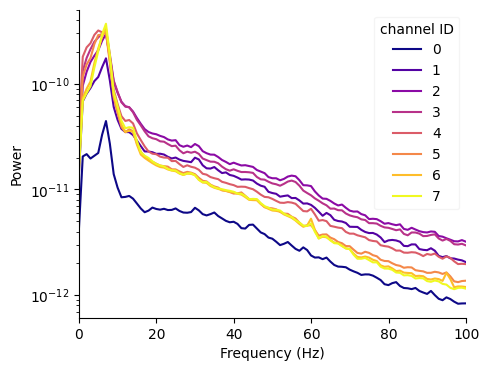

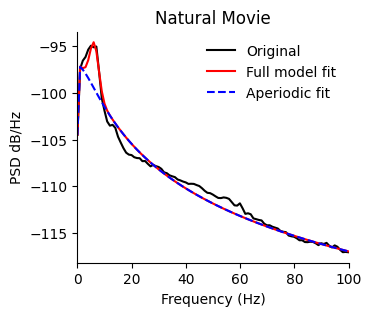

In [15]:
redo = True
while redo:
    ap_knee, = get_parameters({'natural_movie1_knee': True}, parameters_dict, enter_parameters)
    aperiodic_mode = 'knee' if ap_knee else 'fixed'

    _, presentations_ids, presentations_times, trial_duration = align_movie(stimulus_presentations, stimulus_name='natural_movie_one')
    aligned_lfp = align_trials(lfp_array, presentations_ids, presentations_times, window=(0., trial_duration))
    psd_avg = trial_psd(aligned_lfp, tseg=psd_tseg).mean(dim='presentation_id')
    fooof_result, fig1, fig2 = plot_channel_psd(psd_avg, channel_id=group_id, freq_range=200., plt_range=plt_range, figsize=(5, 4),
                         aperiodic_mode=aperiodic_mode, dB_threshold=3., max_n_peaks=10, plot=not savefig, plt_log=True)

    psd_avg_das['natural_movie_one'] = psd_avg
    if savefig:
        fig2, ax = plt.subplots(figsize=(3.5, 3))
        psd_avg_plt = psd_avg.sel(channel=group_id, frequency=slice(*plt_range))
        _ = plot_fooof(psd_avg_plt.frequency.values, psd_avg_plt.values, fooof_result[0], plt_log=False, plt_range=plt_range, plt_db=True, ax=ax)
        ax.set_title('Natural Movie')
    fig_disp({'natural_movie1_psd': fig1, f'natural_movie1_fooof_channel_{group_id}': fig2})

    redo = whether_redo()

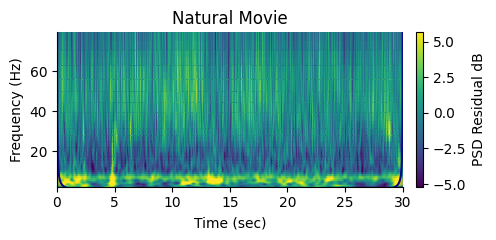

In [16]:
redo = True
while redo:
    channel_ids, = get_parameters({'scaleogram_channels': list(map(int, lfp_array.channel))}, parameters_dict, enter_parameters)

    sxx_avg = trial_averaged_spectrogram(aligned_lfp, tseg=.5)
    axs = plot_channel_spectrogram(sxx_avg, channel_id=channel_ids, plt_range=sxx_plt_range, log_power='dB',
                                   clr_freq_range=(30., 80.), pad=0.03, figsize=(5, 2.5),
                                   remove_aperiodic={'freq_range': 200., 'aperiodic_mode': aperiodic_mode})
    if savefig:
        axs[0, 0].set_title('Natural Movie')
    fig_disp('natural_movie1_scaleogram')

    redo = whether_redo()

### natural_movie_three

Channel:  4
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 1 - 200 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -8.1813, 36.8147, 1.7652                                     
                                                                                                  
                                       2 peaks were found:                                       

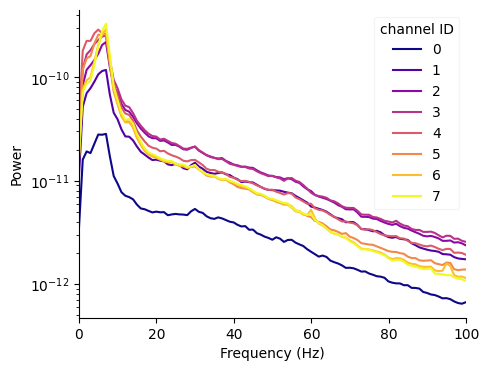

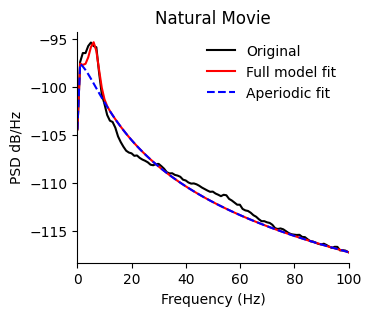

In [17]:
redo = True
while redo:
    ap_knee, = get_parameters({'natural_movie1_knee': True}, parameters_dict, enter_parameters)
    aperiodic_mode = 'knee' if ap_knee else 'fixed'

    _, presentations_ids, presentations_times, trial_duration = align_movie(stimulus_presentations, stimulus_name='natural_movie_three')
    aligned_lfp = align_trials(lfp_array, presentations_ids, presentations_times, window=(0., trial_duration))
    psd_avg = trial_psd(aligned_lfp, tseg=psd_tseg).mean(dim='presentation_id')
    fooof_result, fig1, fig2 = plot_channel_psd(psd_avg, channel_id=group_id, freq_range=200., plt_range=plt_range, figsize=(5, 4),
                         aperiodic_mode=aperiodic_mode, dB_threshold=3., max_n_peaks=10, plot=not savefig, plt_log=True)

    psd_avg_das['natural_movie_three'] = psd_avg
    if savefig:
        fig2, ax = plt.subplots(figsize=(3.5, 3))
        psd_avg_plt = psd_avg.sel(channel=group_id, frequency=slice(*plt_range))
        _ = plot_fooof(psd_avg_plt.frequency.values, psd_avg_plt.values, fooof_result[0], plt_log=False, plt_range=plt_range, plt_db=True, ax=ax)
        ax.set_title('Natural Movie')
    fig_disp({'natural_movie3_psd': fig1, f'natural_movie3_fooof_channel_{group_id}': fig2})

    redo = whether_redo()

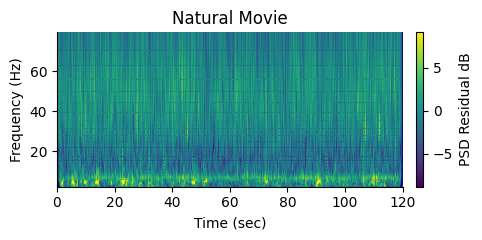

In [18]:
redo = True
while redo:
    channel_ids, = get_parameters({'scaleogram_channels': list(map(int, lfp_array.channel))}, parameters_dict, enter_parameters)

    sxx_avg = trial_averaged_spectrogram(aligned_lfp, tseg=.5)
    axs = plot_channel_spectrogram(sxx_avg, channel_id=channel_ids, plt_range=sxx_plt_range, log_power='dB',
                                   clr_freq_range=(30., 80.), pad=0.03, figsize=(5, 2.5),
                                   remove_aperiodic={'freq_range': 200., 'aperiodic_mode': aperiodic_mode})
    if savefig:
        axs[0, 0].set_title('Natural Movie')
    fig_disp('natural_movie3_scaleogram')

    redo = whether_redo()

#### Save PSD data

In [19]:
good_pattern = 0 if input('Is the PSD pattern good [y/n]?').lower() == 'n' else 1  # default is good

psd_filepath = os.path.join(probe_dir, f'{ecephys_structure_acronym:s}_psd_channel_groups.nc')
for stim, da in psd_avg_das.items():
    # distinguish inconsistent frequency before merging
    psd_avg_das[stim] = da.rename(frequency=f'frequency_{stim:s}')
psd_avg_ds = xr.Dataset(psd_avg_das)
psd_avg_ds = psd_avg_ds.assign_attrs(session_id=session_id, center_unit_group_id=group_id, good_pattern=good_pattern)
psd_avg_ds.to_netcdf(psd_filepath)

### drifting_gratings conditions

In [20]:
condition_id, cond_presentation_id = presentation_conditions(
    drifting_gratings_presentations, condtion_types=['orientation', 'temporal_frequency'])

drifting_gratings_cond_psd = [drifting_gratings_psd.sel(presentation_id=i).mean(dim='presentation_id') for i in cond_presentation_id.values()]
drifting_gratings_cond_psd = xr.concat(drifting_gratings_cond_psd, dim=pd.Index(cond_presentation_id, name='condition_id'))
drifting_gratings_cond_psd = drifting_gratings_cond_psd.sel(condition_id=condition_id)

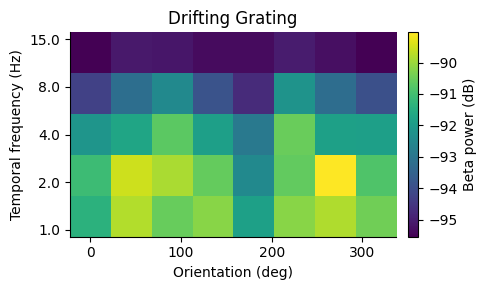

In [21]:
freq_band = (20., 40.)

redo = True
while redo:
    freq_band, = get_parameters({'power_freq_band': freq_band}, parameters_dict, enter_parameters)

    cond_band_power = drifting_gratings_cond_psd.sel(frequency=slice(*freq_band)).integrate('frequency')
    cond_band_power = cond_band_power.sel(channel=[group_id])

    temporal_frequency = cond_band_power.temporal_frequency.values
    nchannel = cond_band_power.coords['channel'].size

    _, axs = plt.subplots(nchannel, 1, squeeze=False, figsize=(5, 3 * nchannel))
    for c, ax in zip(cond_band_power.channel, axs.ravel()):
        cpower = cond_band_power.sel(channel=c).T
        cpower[:] = 10 * np.log10(cpower)
        cpower.plot.imshow(ax=ax, cbar_kwargs=dict(label='Beta power (dB)', pad=0.03))
        ax.set_yticks(np.linspace(temporal_frequency[0], temporal_frequency[-1], temporal_frequency.size))
        ax.set_yticklabels(temporal_frequency)
        ax.set_xlabel('Orientation (deg)')
        ax.set_ylabel('Temporal frequency (Hz)')
    plt.tight_layout()

    if savefig:
        axs[0, 0].set_title('Drifting Grating')
    fig_disp(f'drifting_grating_power_band_{freq_band[0]:g}-{freq_band[1]:g}')

    redo = whether_redo()


temporal_frequency:  1.0 Hz
Channel:  4
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 1 - 200 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                    -7.3442, 102.3243, 2.1565                                     
                                                                                                  
                                       3 peaks were found:          

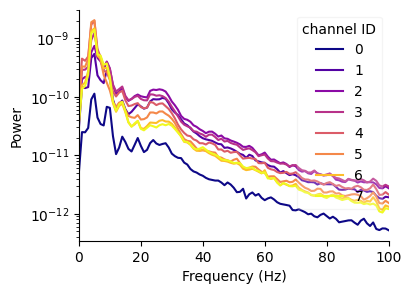

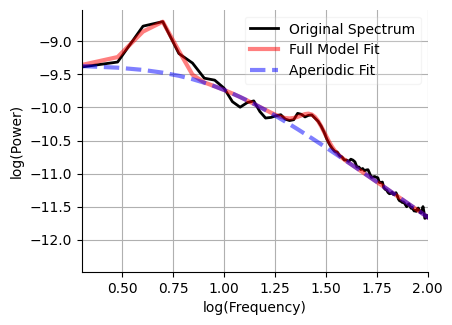


temporal_frequency:  2.0 Hz
Channel:  4
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 1 - 200 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                    -7.1604, 231.6324, 2.2514                                     
                                                                                                  
                                       3 peaks were found:          

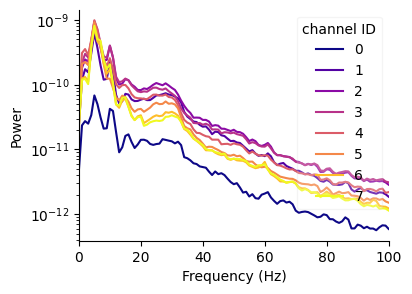

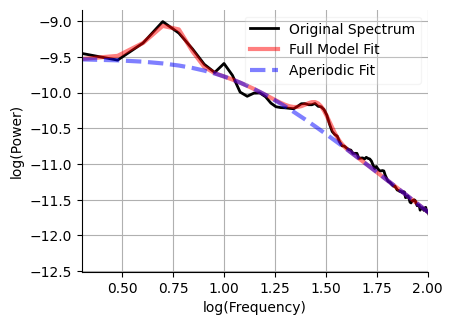


temporal_frequency:  4.0 Hz
Channel:  4
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 1 - 200 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                    -7.3958, 161.0412, 2.1567                                     
                                                                                                  
                                       3 peaks were found:          

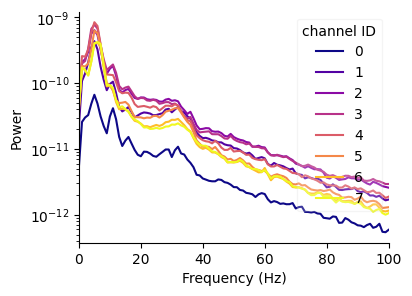

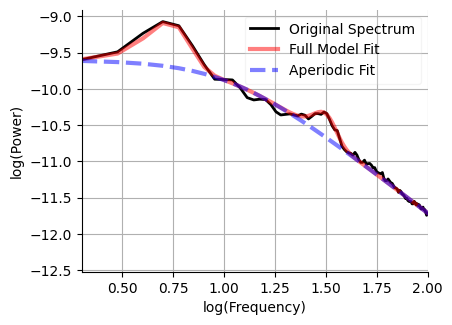


temporal_frequency:  8.0 Hz
Channel:  4
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 1 - 200 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                    -7.3733, 220.7591, 2.1879                                     
                                                                                                  
                                       2 peaks were found:          

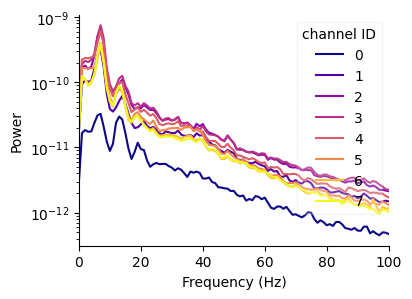

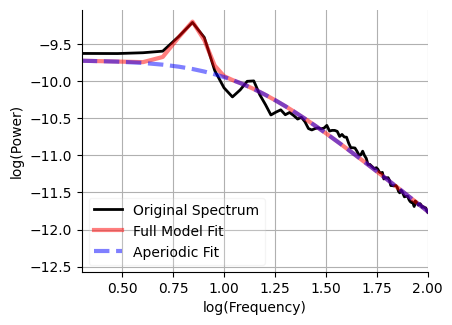


temporal_frequency:  15.0 Hz
Channel:  4
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 1 - 200 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.9966, 48.7410, 1.9291                                     
                                                                                                  
                                       5 peaks were found:         

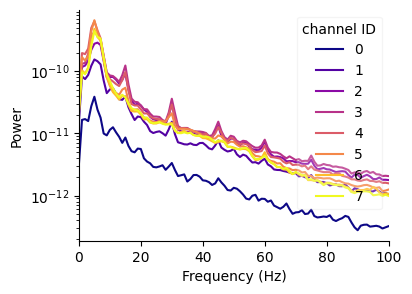

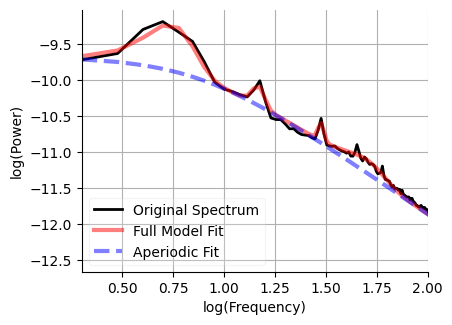

In [22]:
redo = True
while redo:
    ap_knee, = get_parameters({'drifting_gratings_knee': True}, parameters_dict, enter_parameters=False)
    aperiodic_mode = 'knee' if ap_knee else 'fixed'

    tfreq_psd = drifting_gratings_cond_psd.mean(dim='orientation')
    for freq in drifting_gratings_cond_psd.temporal_frequency.values:
        print(f'\ntemporal_frequency: {freq: .1f} Hz')
        _, fig1, fig2 = plot_channel_psd(tfreq_psd.sel(temporal_frequency=freq), channel_id=group_id,
                             freq_range=200., plt_range=plt_range, figsize=(4, 3),
                             aperiodic_mode=aperiodic_mode, dB_threshold=3., max_n_peaks=10, plt_log=True)
        fig_disp({f'drifting_grating_tfreq_{freq:g}_psd': fig1, f'drifting_grating_tfreq_{freq:g}_fooof_channel_{group_id}': fig2})

    redo = whether_redo()


temporal_frequency:  1.0 Hz


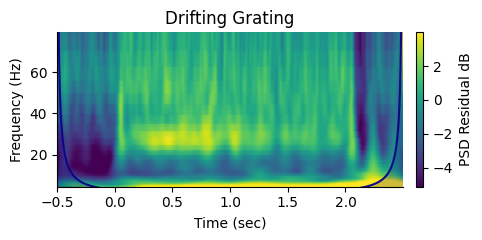


temporal_frequency:  2.0 Hz


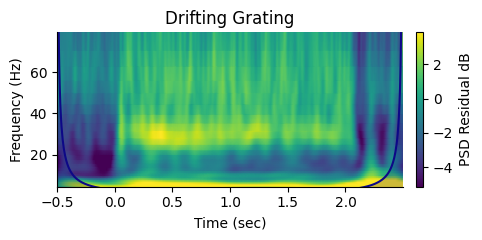


temporal_frequency:  4.0 Hz


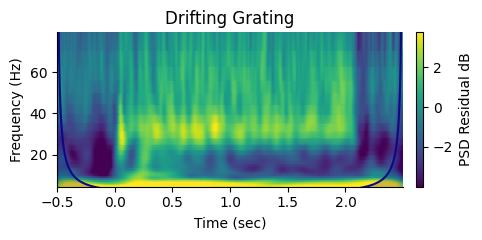


temporal_frequency:  8.0 Hz


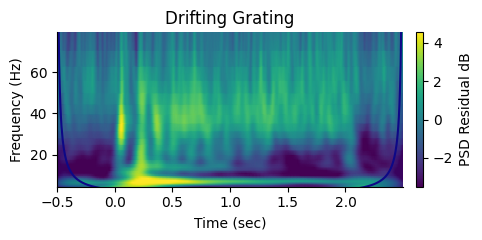


temporal_frequency:  15.0 Hz


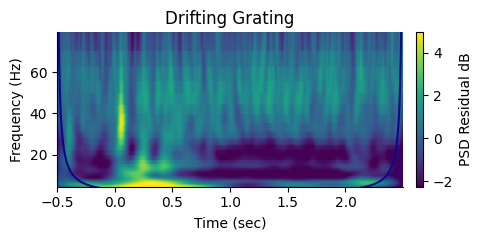

In [23]:
redo = True
while redo:
    channel_ids, = get_parameters({'scaleogram_channels': list(map(int, lfp_array.channel))}, parameters_dict, enter_parameters)

    grating_aligned_lfp = align_trials(lfp_array, grating_ids, grating_times, window=(-0.5, grating_duration + 0.5))

    for freq in condition_id.temporal_frequency.values:
        print(f'\ntemporal_frequency: {freq: .1f} Hz')
        present_ids = np.concatenate([cond_presentation_id[i] for i in condition_id.sel(temporal_frequency=freq).values])
        sxx_avg = trial_averaged_spectrogram(grating_aligned_lfp.sel(presentation_id=present_ids), tseg=.25)
        axs = plot_channel_spectrogram(sxx_avg, channel_id=channel_ids, plt_range=sxx_plt_range, log_power='dB',
                                       clr_freq_range=(25., 40.), pad=0.03, figsize=(5, 2.5),
                                       remove_aperiodic={'freq_range': 200., 'aperiodic_mode': aperiodic_mode})
        if savefig:
            axs[0, 0].set_title('Drifting Grating')
        fig_disp(f'drifting_grating_tfreq_{freq:g}_scaleogram')

    redo = whether_redo()

## Save parameters in config

In [24]:
with open(info_file, 'w') as f:
    json.dump(info, f, indent=4)